In [1]:
import json
from pathlib import Path

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
import torch
from albumentations.pytorch import ToTensorV2
from skimage import io
from torch.utils.data import DataLoader
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

from intelligent_placer_lib.dataset.segmentation import SegmentationDataset
from intelligent_placer_lib.model.segmentation import SegmentationModelPL
from intelligent_placer_lib.dataset.wrapper import FiniteWrapperDataset

In [2]:
def make_objects_with_masks():
    object_images = []
    object_masks = []

    for i, img_path in enumerate(Path('data/').glob('*.jpg')):
        json_path = Path(img_path.parent) / (img_path.stem + '.json')

        img = io.imread(img_path)

        with open(json_path, 'r') as f:
            data = json.load(f)
        polygon_coords = np.array(data['shapes'][0]['points'], dtype=np.int32)

        mask = cv2.fillPoly(np.zeros(img.shape[:2]), [polygon_coords], 1)

        bbox = np.array([np.min(polygon_coords[:, 0]), np.min(polygon_coords[:, 1]),
                         np.max(polygon_coords[:, 0]), np.max(polygon_coords[:, 1])], dtype=np.int32)
        box_width = bbox[2] - bbox[0]
        box_height = bbox[3] - bbox[1]
        new_box_size = np.int32(np.ceil(2 ** 0.5 * max(box_width, box_height)))
        x1 = (bbox[0] + bbox[2]) // 2 - new_box_size // 2
        y1 = (bbox[1] + bbox[3]) // 2 - new_box_size // 2
        bbox = np.array([x1, y1, x1 + new_box_size, y1 + new_box_size])

        q = np.quantile(img, 0.97)
        img = np.clip(img / q * 255, 0, 255).astype(np.uint8)

        obj_image = (np.uint8(mask[..., np.newaxis]) * img)[bbox[1]: bbox[3], bbox[0]: bbox[2]]
        obj_mask = np.uint8(mask)[bbox[1]: bbox[3], bbox[0]: bbox[2]]

        object_images.append(obj_image)
        object_masks.append(obj_mask)

    return object_images, object_masks

In [3]:
backgrounds = [np.uint8(0.4 * io.imread(f'data/background/sample{i}.jpg')) for i in range(2, 7)]

In [4]:
object_images, object_masks = make_objects_with_masks()

transform = A.Compose([
    A.MultiplicativeNoise(multiplier=(0.8, 1.05), per_channel=True),
    A.Perspective(scale=(0.01, 0.05), pad_mode=cv2.BORDER_REPLICATE, always_apply=True),
    A.GaussianBlur((21, 31), p=0.5),
    A.Resize(640, 400, interpolation=cv2.INTER_NEAREST),
    ToTensorV2(transpose_mask=True)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.9))

dataset = FiniteWrapperDataset(SegmentationDataset(object_images, object_masks,
                                                   image_shape=(1280, 800),
                                                   paper_shape=(700, 500),
                                                   border_spacing=10,
                                                   top_bottom_sep_y=800,
                                                   num_objects=3,
                                                   paper_color=[200, 200, 190],
                                                   polygon_spacing=40,
                                                   polygon_size=350,
                                                   background_samples=backgrounds,
                                                   transform=transform), 200)

In [19]:
def collate_fn(samples):
    return samples

loader = DataLoader(dataset, 5, collate_fn=collate_fn)

In [17]:
net = SegmentationModelPL(input_shape=(640, 400))
trainer = pl.Trainer(max_epochs=280, accumulate_grad_batches={0:1, 40: 3},
                     logger=pl.loggers.CSVLogger('.'))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [20]:
trainer.fit(model=net, train_dataloaders=loader, ckpt_path='C:/Users/Aleksandr_Timofeev2/Downloads/segmentation (3).checkpoint')
trainer.save_checkpoint('segmentation.checkpoint')

Restoring states from the checkpoint path at C:/Users/Aleksandr_Timofeev2/Downloads/segmentation (3).checkpoint
c:\users\aleksandr_timofeev2\documents\intelligentplacer\venv\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:250: UserWarning: You're resuming from a checkpoint that ended mid-epoch. Training will start from the beginning of the next epoch. This can cause unreliable results if further training is done, consider using an end of epoch checkpoint.
  rank_zero_warn(
Restored all states from the checkpoint file at C:/Users/Aleksandr_Timofeev2/Downloads/segmentation (3).checkpoint

  | Name  | Type     | Params
-----------------------------------
0 | model | MaskRCNN | 41.0 M
-----------------------------------
41.0 M    Trainable params
0         Non-trainable params
41.0 M    Total params
164.013   Total estimated model params size (MB)
c:\users\aleksandr_timofeev2\documents\intelligentplacer\venv\lib\site-packages\pytorch_lightning\trainer\data_lo

Training: 0it [00:00, ?it/s]

c:\users\aleksandr_timofeev2\documents\intelligentplacer\venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


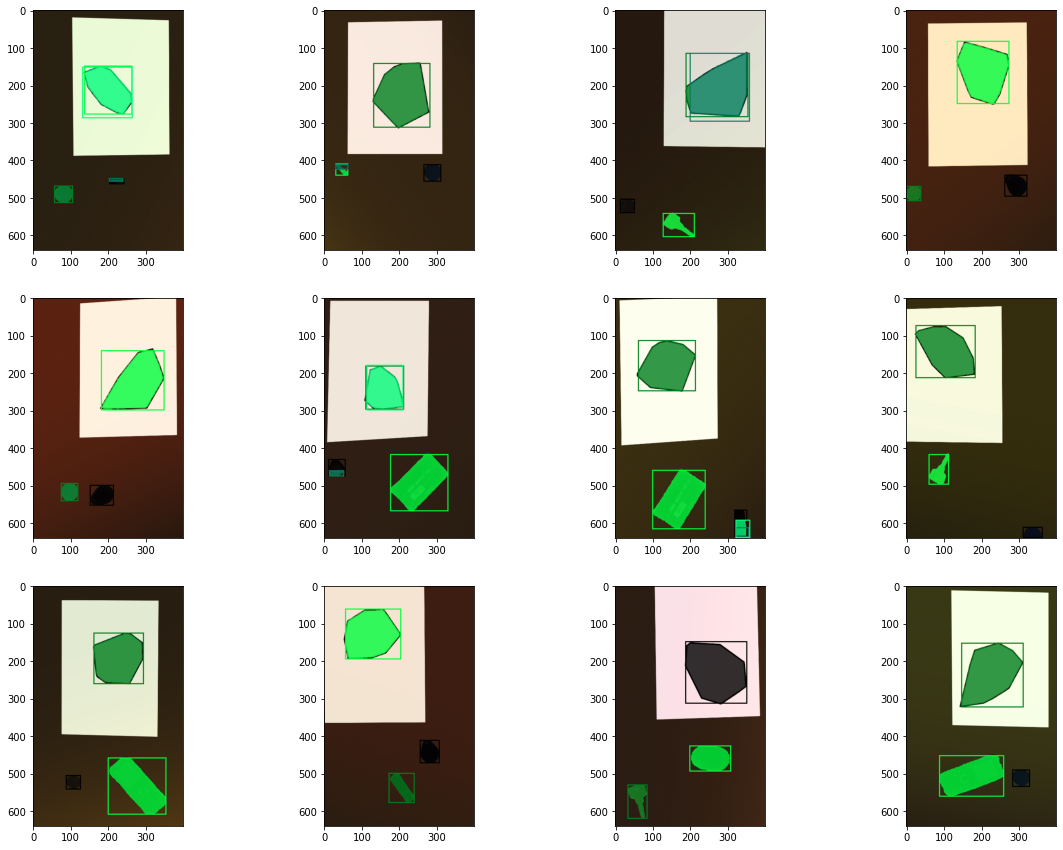

In [134]:
n = 5

ncols = 4
nrows = 3

fig, ax = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))

for i in range(ncols * nrows):
    sample = next(iter(dataset))

    xs = [sample['image']]

    preds = net.model.eval()(xs)[0]

    img_with_masks = draw_segmentation_masks((255 * xs[0]).type(torch.uint8), preds['masks'].squeeze() > 0.5)
    img_with_boxes = draw_bounding_boxes(img_with_masks, preds['boxes'], width=3)

    ax.flatten()[i].imshow(np.moveaxis(img_with_boxes.numpy(), 0, -1))

In [135]:
img = io.imread(Path('data/real_images/photo5354966934506027628.jpg'))

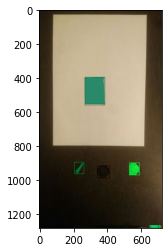

In [144]:
from torchvision.ops import nms

res = net.model.eval()([torch.tensor(np.moveaxis(np.float32(img / 255), -1, 0))])[0]

idx = nms(res['boxes'], res['scores'], 0.1)

res['boxes'] = res['boxes'][idx]
res['scores'] = res['scores'][idx]
res['labels'] = res['labels'][idx]
res['masks'] = res['masks'][idx]

img_with_masks = draw_segmentation_masks(torch.tensor(np.moveaxis(img, -1, 0)), res['masks'].squeeze() > 0.5)
img_with_boxes = draw_bounding_boxes(img_with_masks, res['boxes'], width=3)

plt.imshow(np.moveaxis(img_with_boxes.numpy(), 0, -1))

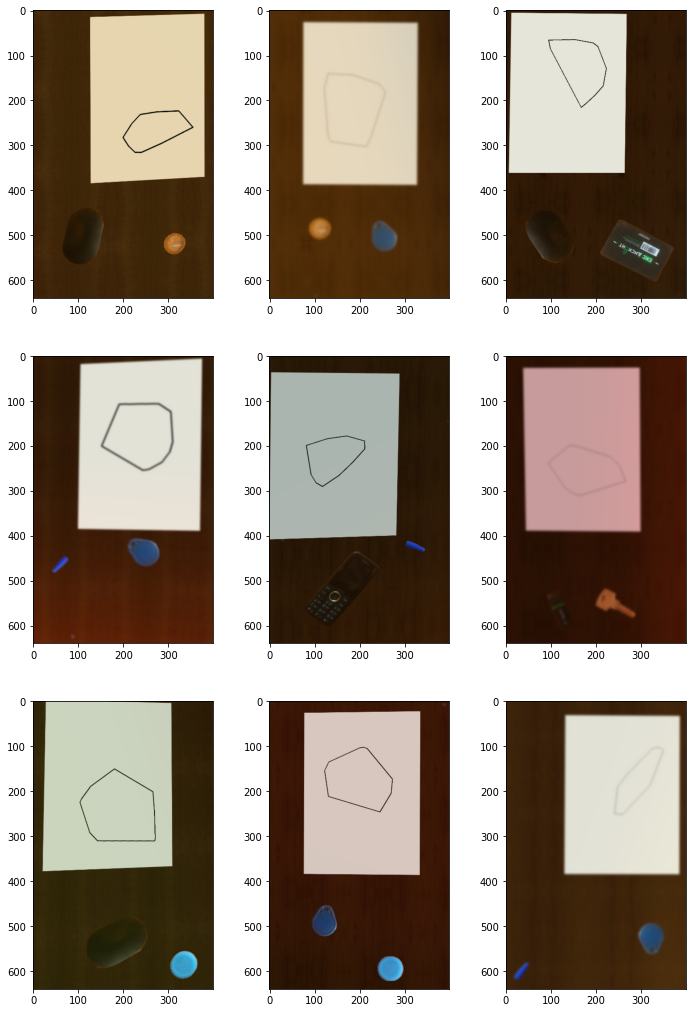

In [23]:
ncols = 3
nrows = 3

fig, ax = plt.subplots(nrows, ncols, figsize=(4*ncols, 6*nrows))

for i in range(ncols * nrows):
    sample = next(iter(dataset))
    ax.flatten()[i].imshow(np.moveaxis(sample['image'].numpy(), 0, -1))

In [21]:
torch.save(net.model.state_dict(), 'segmentation_weights.pth')